In [1]:
%matplotlib inline
import os 
import numpy as np 
import seaborn as sns 
import nibabel as nb 
import pandas as pd 
import matplotlib.pyplot as plt 
from matplotlib.colors import ListedColormap
sns.set_style('white')

workspace_dir  = '/Users/kanaan/Google Drive/TS-EUROTRAIN/RESULTS_QSMv3/dataframes'
#workspace_dir  = '/scr/malta3/workspace/project_iron/phenotypic'
pheno_dir      = os.path.join(workspace_dir, 'phenotypic')
clinical_dir   = os.path.join(workspace_dir, 'DF_clinical')
save_fig_dir        = '/Users/kanaan/Google Drive/TS-EUROTRAIN/Papers/2016_QSM_paper/Figures_python_v4'


In [2]:
def return_qsm_data(subject, nucleus):
    subdir = os.path.join(workspace_dir, subject)
    #qsm = np.rot90(nb.load(os.path.join(subdir, 'QSM_denoised.nii.gz')).get_data())
    qsm = np.rot90(nb.load(os.path.join(subdir, 'QSM_denoised.nii.gz')).get_data())# * - 100
    uni = np.rot90(nb.load(os.path.join(subdir, 'MP2RAGE2FLASH_BRAIN.nii.gz')).get_data()) #/  350
    
    if nucleus in ['RN','SN','STN','DN']:
        l = np.rot90(nb.load(os.path.join(subdir,'L_%s.nii.gz')%nucleus).get_data())
        r = np.rot90(nb.load(os.path.join(subdir,'R_%s.nii.gz')%nucleus).get_data())
    elif nucleus is 'Pall':
        l = np.rot90(nb.load(os.path.join(subdir,'FIRST_HYBRID-L_Pall_first_thr.nii.gz')).get_data())
        r = np.rot90(nb.load(os.path.join(subdir,'FIRST_HYBRID-R_Pall_first_thr.nii.gz')).get_data())
    elif nucleus is 'Caud_Puta':
        l = np.rot90(nb.load(os.path.join(subdir,'FIRST_HYBRID-L_Caud_first_thr.nii.gz')).get_data()) + \
            np.rot90(nb.load(os.path.join(subdir,'FIRST_HYBRID-L_Puta_first_thr.nii.gz')).get_data())
        r = np.rot90(nb.load(os.path.join(subdir,'FIRST_HYBRID-R_Caud_first_thr.nii.gz')).get_data()) + \
            np.rot90(nb.load(os.path.join(subdir,'FIRST_HYBRID-R_Puta_first_thr.nii.gz')).get_data())
    l[l==0]=np.nan
    r[r==0]=np.nan
    return qsm,uni,l,r      

def edge_detect_ero(i):
    ero  = ndimage.binary_erosion(i,iterations=1).astype(i.dtype)
    edge = i - ero
    edge[edge==0]=np.nan
    return edge

def edge_detect_first(i):
    ero =  ndimage.binary_erosion(i, iterations=2).astype(i.dtype)
    dil =  ndimage.binary_dilation(i, iterations=1).astype(i.dtype)
    sep = dil-ero
    sep = ndimage.binary_erosion(sep, iterations=1).astype(sep.dtype)
    sep[sep==0]=np.nan
    return sep

def make_split_df(dfx, group, measure, hemi):
    df = pd.DataFrame(columns = [measure, 'Population', 'Hemisphere'])
    df[measure]      = dfx['%s_%s'%(hemi[0], measure)] #*1000
    df['Hemisphere'] = hemi
    df['Population'] = group
    return df

In [3]:
controls = pd.read_csv(os.path.join(pheno_dir, 'df_controls_qc.csv'), index_col = 0)
patients = pd.read_csv(os.path.join(pheno_dir, 'df_patients_qc.csv'), index_col = 0)
nuclei  = ['SN', 'STN', 'RN','GPi','Puta','DN']


In [4]:
measures = ['RN','SN','STN','Caud_Puta','Pall','DN']
Brainstem =  ['SN','STN',]
Basalganglia = ['Caud_Puta','Pall','DN']
red = ['RN']

lims = {'cor_x': (45, 160), 'cor_y': (140,10), 'ax_x': (35, 170), 'ax_y':(200,50)}
Zcuts = { 'RN':41, 'STN':130, 'SN':130, 'Pall':64, 'Caud_Puta': 64, 'DN':20}


In [48]:
sns.set(font_scale=2.75)
sns.set_style('white', {"xtick.direction": "in","ytick.direction": "in"})
palette = sns.color_palette("hls", 24)
palette = ['#ea2227' for i in range(40)] #r

#xpal = ['#365fa5',#'#984ea3',
#        '#cb1a1e', 
#          '#368c44', 
#          '#ef8148',
#        ]

xpalX = ['#4575b4','#d73027']
xpal=['#8195e0','#dd787e']

def make_plot(measures,df1,df2,save=0,wspace=None,hspace=None):
    fig = plt.figure()
    fig.set_size_inches(40, 20)
    fig.subplots_adjust(left=None, bottom=None, 
                        right=None, top=None, 
                        wspace=wspace, hspace=hspace)
    
    
    for i, measure in enumerate(measures): 
        c = i 
        c += i*3
        print measure, c 
        ax1 = plt.subplot2grid((2,6),(1,i), colspan=1,rowspan=1)
        data = [df1[measure], df2[measure]] 
  
        #gv = sns.violinplot(data=data, ax = ax1, palette =xpal, inner= 'quart')
        #plt.setp(gv.collections, alpha=.5)
        g = sns.stripplot(data=data, ax = ax1, palette=xpalX, jitter= 0.05, size = 21, linewidth=1.2, marker='.', edgecolor='w')
        g = sns.pointplot(data=data, ax = ax1, color=xpalX[1] ,linestyles=['-'], markers=['o'], )      
        g.set(xticklabels=[])  
        g.set(xlabel=' ',ylabel=' ')
        plt.xticks(fontsize=20, weight='bold')
        plt.yticks(fontsize=22, weight='bold')
        
        qsm, uni, l, r = return_qsm_data('BATP', measure)
        qsm2, uni2, l2, r2 = return_qsm_data('PAHT', measure)
        Zcut =Zcuts[measure]
        ax2 = plt.subplot2grid((2,6),(0,i), colspan=1,rowspan=1)
        
        alphax=0.9
        alphauni=0.5
        if measure in Brainstem:
            print measure
            ax2.imshow(np.rot90(qsm[Zcut,:,:]), interpolation= None, alpha = 1,vmin = -.25, vmax = 0.25, cmap='Greys')
            ax2.imshow(np.rot90(uni[Zcut,:,:]), interpolation= None, alpha = alphauni, cmap='Greys')
            ax2.imshow(np.rot90(l[Zcut,:,:]), interpolation= None, cmap= ListedColormap(palette[c]),alpha =alphax)
            ax2.imshow(np.rot90(r[Zcut,:,:]), interpolation= None, cmap= ListedColormap(palette[c]),alpha =alphax)
            ax2.set_xlim(lims['cor_x'][0],lims['cor_x'][1])
            ax2.set_ylim(lims['cor_y'][0],lims['cor_y'][1])
        elif measure in red:
            ax2.imshow(qsm2[:,:,Zcut], interpolation= None, alpha = 1,vmin = -.25, vmax = 0.25, cmap='Greys')
            ax2.imshow(uni2[:,:,Zcut], interpolation= None, alpha = alphauni, cmap='Greys')
            ax2.imshow(l2[:,:,Zcut], interpolation= None, cmap= ListedColormap(palette[c]),alpha =alphax)
            ax2.imshow(r2[:,:,Zcut], interpolation= None, cmap= ListedColormap(palette[c]),alpha =alphax)
            ax2.set_xlim(35, 170)
            ax2.set_ylim(203,50)
            
        elif measure in Basalganglia:
            print measure
            ax2.imshow(qsm[:,:,Zcut], interpolation= None, alpha = 1,vmin = -.25, vmax = 0.25, cmap='Greys')
            ax2.imshow(uni[:,:,Zcut], interpolation= None, alpha = alphauni, cmap='Greys')
            ax2.imshow(l[:,:,Zcut], interpolation= None, cmap= ListedColormap(palette[c]),alpha =alphax)
            ax2.imshow(r[:,:,Zcut], interpolation= None, cmap= ListedColormap(palette[c]),alpha =alphax)
            if measure == 'DN':
                ax2.set_xlim(35, 170)
                ax2.set_ylim(230,80)
            else:    
                ax2.set_xlim(lims['ax_x'][0],lims['ax_x'][1])
                ax2.set_ylim(lims['ax_y'][0],lims['ax_y'][1])
        
        ax2.set_xticklabels = []
        ax2.set_yticklabels = []
        ax2.axes.get_yaxis().set_visible(False)
        ax2.axes.get_xaxis().set_visible(False)
        ax2.grid(False)
        ax2.tick_params(axis='x', labelsize=5)
        ax2.tick_params(axis='y', labelsize=25)
    
    
    #plt.tight_layout()
    
    if save:
        fig.savefig(os.path.join(save_fig_dir, 'stats_qsm_x1.png'),
                    dpi = 300, bbox_inches='tight', transparent = True)

RN 0
SN 4
SN
STN 8
STN
Caud_Puta 12
Caud_Puta
Pall 16
Pall
DN 20
DN


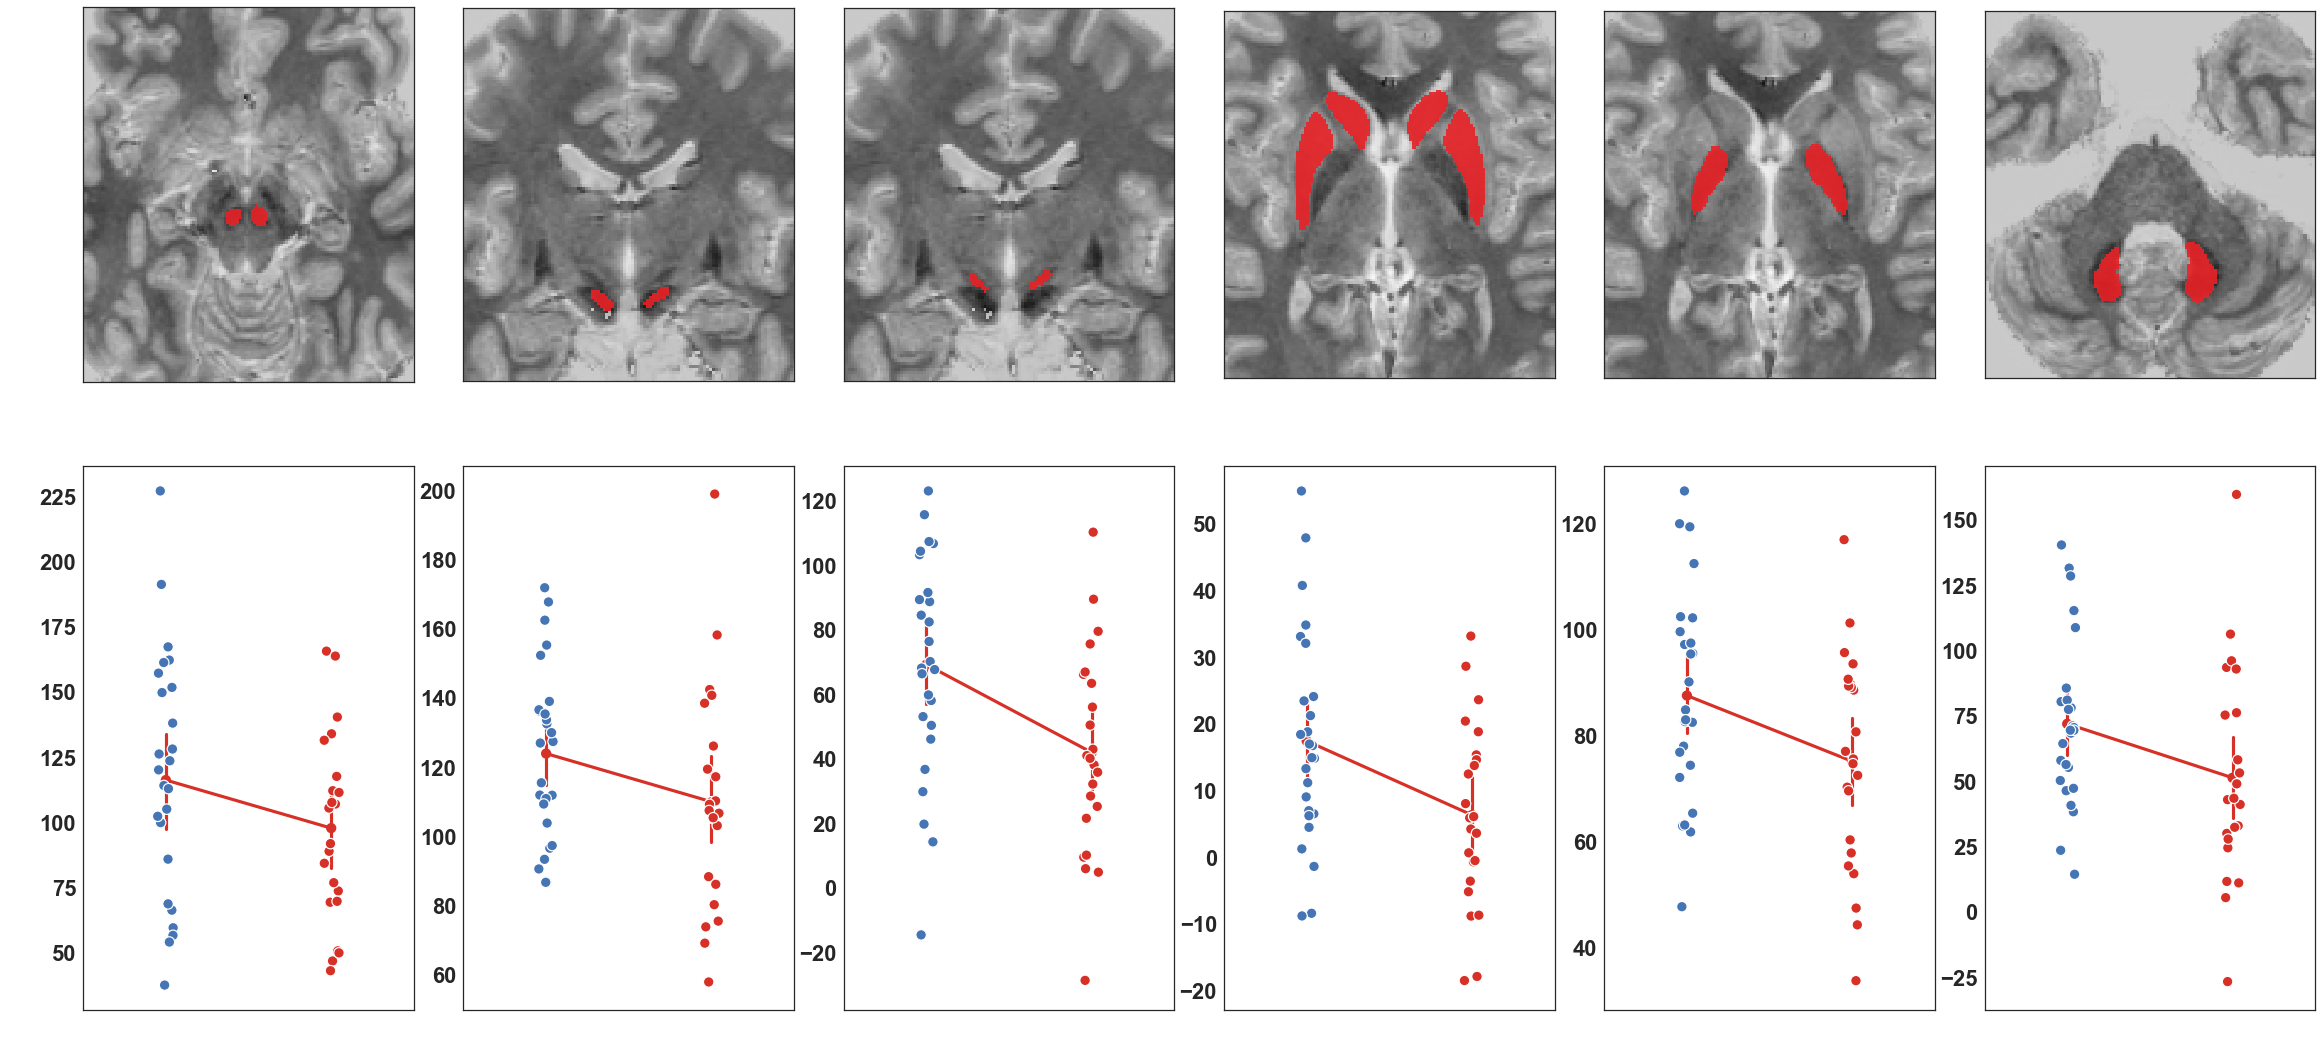

In [6]:
make_plot(measures,controls,patients, save = 1,wspace=0.15, hspace=0.00001)

In [51]:
sns.set(font_scale=2.75)
sns.set_style('white', {"xtick.direction": "in","ytick.direction": "in"})
palette = sns.color_palette("hls", 24)
palette = ['#ff0a0a' for i in range(40)]
#palette = ['#fbed1f' for i in range(40)] #y


#xpal = ['#365fa5',#'#984ea3',
#        '#cb1a1e', 
#          '#368c44', 
#          '#ef8148',
#        ]

xpalX = ['#4575b4','#d73027']
xpal=['#8195e0','#dd787e']

def make_plot(measures,df1,df2,plt_type, save=0,wspace=None,hspace=None):
    fig = plt.figure()
    fig.set_size_inches(40, 20)
    fig.subplots_adjust(left=None, bottom=None, 
                        right=None, top=None, 
                        wspace=wspace, hspace=hspace)
    
    
    for i, measure in enumerate(measures): 
        c = i 
        c += i*3
        print measure, c 
        ax1 = plt.subplot2grid((2,6),(1,i), colspan=1,rowspan=1)
        data = [df1[measure], df2[measure]] 
  

        if plt_type is 'violin':
            g = sns.violinplot(data=data, ax = ax1, palette =xpal, inner= 'quart')
            plt.setp(g.collections, alpha=.5)
            plt.xticks(fontsize=20, weight='bold')
            plt.yticks(fontsize=22, weight='bold')
            g.set(xticklabels=[])  
            g.set(xlabel=' ',ylabel=' ')
            plt.ylim(ylims[measure])
            def patch_violinplot():
                """Patch seaborn's violinplot in current axis to workaround matplotlib's bug ##5423."""
                from matplotlib.collections import PolyCollection
                ax = plt.gca()
                for art in ax.get_children():
                    if isinstance(art, PolyCollection):
                        art.set_edgecolor(None)
            patch_violinplot()
            
            
        if plt_type is 'violin2':
            g = sns.violinplot(data=data, ax = ax1, palette =xpal, inner= None)
            plt.setp(g.collections, alpha=.5)
            plt.xticks(fontsize=20, weight='bold')
            plt.yticks(fontsize=22, weight='bold')
            g.set(xticklabels=[])  
            g.set(xlabel=' ',ylabel=' ')
            plt.ylim(ylims[measure])
            def patch_violinplot():
                """Patch seaborn's violinplot in current axis to workaround matplotlib's bug ##5423."""
                from matplotlib.collections import PolyCollection
                ax = plt.gca()
                for art in ax.get_children():
                    if isinstance(art, PolyCollection):
                        art.set_edgecolor(None)
            patch_violinplot()
    
        

        elif plt_type is 'scatter':
            g = sns.stripplot(data=data, ax = ax1, palette=xpalX, jitter= 0.05, size = 20, linewidth=1.2, marker='.', edgecolor=None)
            g = sns.pointplot(data=data, ax = ax1, color=xpalX[1] ,linestyles=['-'], markers=['o'], )      
            plt.xticks(fontsize=20, weight='bold')
            plt.yticks(fontsize=22, weight='bold')
            g.set(xticklabels=[])  
            g.set(xlabel=' ',ylabel=' ')
            plt.ylim(ylims[measure])                                                    

        elif plt_type is 'img':
            qsm, uni, l, r = return_qsm_data('BATP', measure)
            qsm2, uni2, l2, r2 = return_qsm_data('PAHT', measure)
            Zcut =Zcuts[measure]
            ax2 = plt.subplot2grid((2,6),(0,i), colspan=1,rowspan=1)

            alphax=0.9
            alphauni=0.4
            if measure in Brainstem:
                print measure
                ax2.imshow(np.rot90(qsm[Zcut,:,:]), interpolation= None, alpha = 1,vmin = -.2, vmax = 0.2, cmap='Greys')
                ax2.imshow(np.rot90(uni[Zcut,:,:]), interpolation= None, alpha = alphauni, cmap='Greys')
                ax2.imshow(np.rot90(l[Zcut,:,:]), interpolation= None, cmap= ListedColormap(palette[c]),alpha =alphax)
                ax2.imshow(np.rot90(r[Zcut,:,:]), interpolation= None, cmap= ListedColormap(palette[c]),alpha =alphax)
                ax2.set_xlim(lims['cor_x'][0],lims['cor_x'][1])
                ax2.set_ylim(lims['cor_y'][0],lims['cor_y'][1])
            elif measure in red:
                ax2.imshow(qsm2[:,:,Zcut], interpolation= None, alpha = 1,vmin = -.25, vmax = 0.25, cmap='Greys')
                ax2.imshow(uni2[:,:,Zcut], interpolation= None, alpha = alphauni, cmap='Greys')
                ax2.imshow(l2[:,:,Zcut], interpolation= None, cmap= ListedColormap(palette[c]),alpha =alphax)
                ax2.imshow(r2[:,:,Zcut], interpolation= None, cmap= ListedColormap(palette[c]),alpha =alphax)
                ax2.set_xlim(35, 170)
                ax2.set_ylim(203,50)

            elif measure in Basalganglia:
                print measure
                ax2.imshow(qsm[:,:,Zcut], interpolation= None, alpha = 1,vmin = -.25, vmax = 0.25, cmap='Greys')
                ax2.imshow(uni[:,:,Zcut], interpolation= None, alpha = alphauni, cmap='Greys')
                ax2.imshow(l[:,:,Zcut], interpolation= None, cmap= ListedColormap(palette[c]),alpha =alphax)
                ax2.imshow(r[:,:,Zcut], interpolation= None, cmap= ListedColormap(palette[c]),alpha =alphax)
                if measure == 'DN':
                    ax2.set_xlim(35, 170)
                    ax2.set_ylim(230,80)
                else:    
                    ax2.set_xlim(lims['ax_x'][0],lims['ax_x'][1])
                    ax2.set_ylim(lims['ax_y'][0],lims['ax_y'][1])

            ax2.set_xticklabels = []
            ax2.set_yticklabels = []
            ax2.axes.get_yaxis().set_visible(False)
            ax2.axes.get_xaxis().set_visible(False)
            ax2.grid(False)
            ax2.tick_params(axis='x', labelsize=5)
            ax2.tick_params(axis='y', labelsize=25)
    
    #plt.tight_layout()
    
    if save:
        fig.savefig(os.path.join(save_fig_dir, 'stats_qsm_%s.png'%plt_type),
                    dpi = 300, bbox_inches='tight', transparent = True)

RN 0
SN 4
STN 8
Caud_Puta 12
Pall 16
DN 20
RN 0
SN 4
STN 8
Caud_Puta 12
Pall 16
DN 20


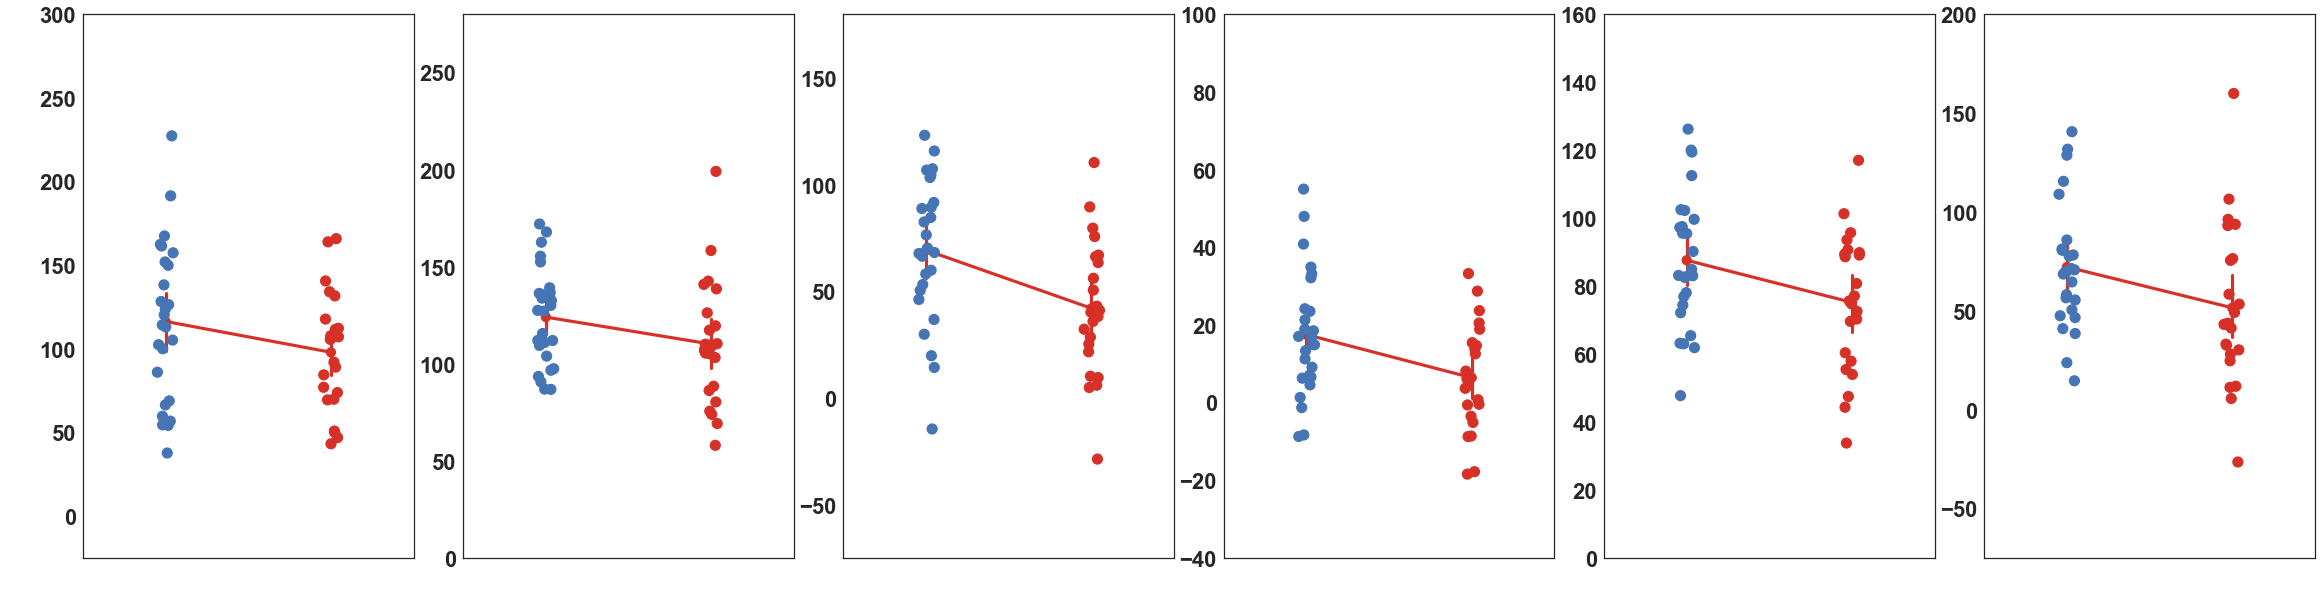

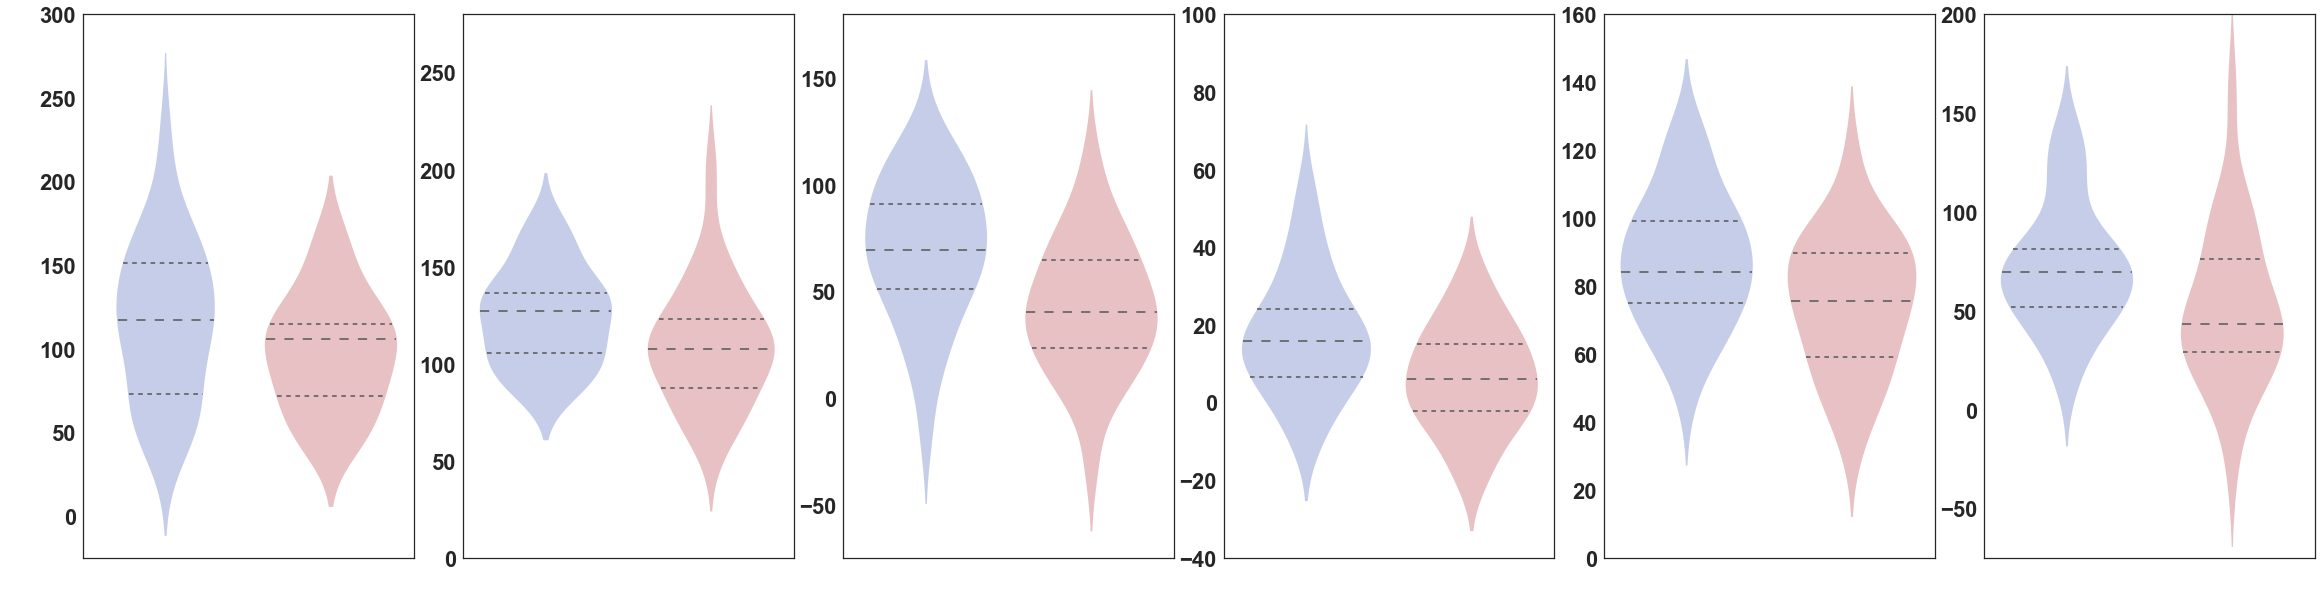

In [47]:
ylims = { 'RN':(-25,300), 'SN':(0,280), 'STN':(-75,180), 'Caud_Puta': (-40,100), 'Pall':(0,160), 'DN':(-75,200)}

make_plot(measures,controls,patients, plt_type='scatter', save =1,wspace=0.15, hspace=0.00001)
make_plot(measures,controls,patients, plt_type='violin', save = 1,wspace=0.15, hspace=0.00001)

RN 0
SN 4
STN 8
Caud_Puta 12
Pall 16
DN 20


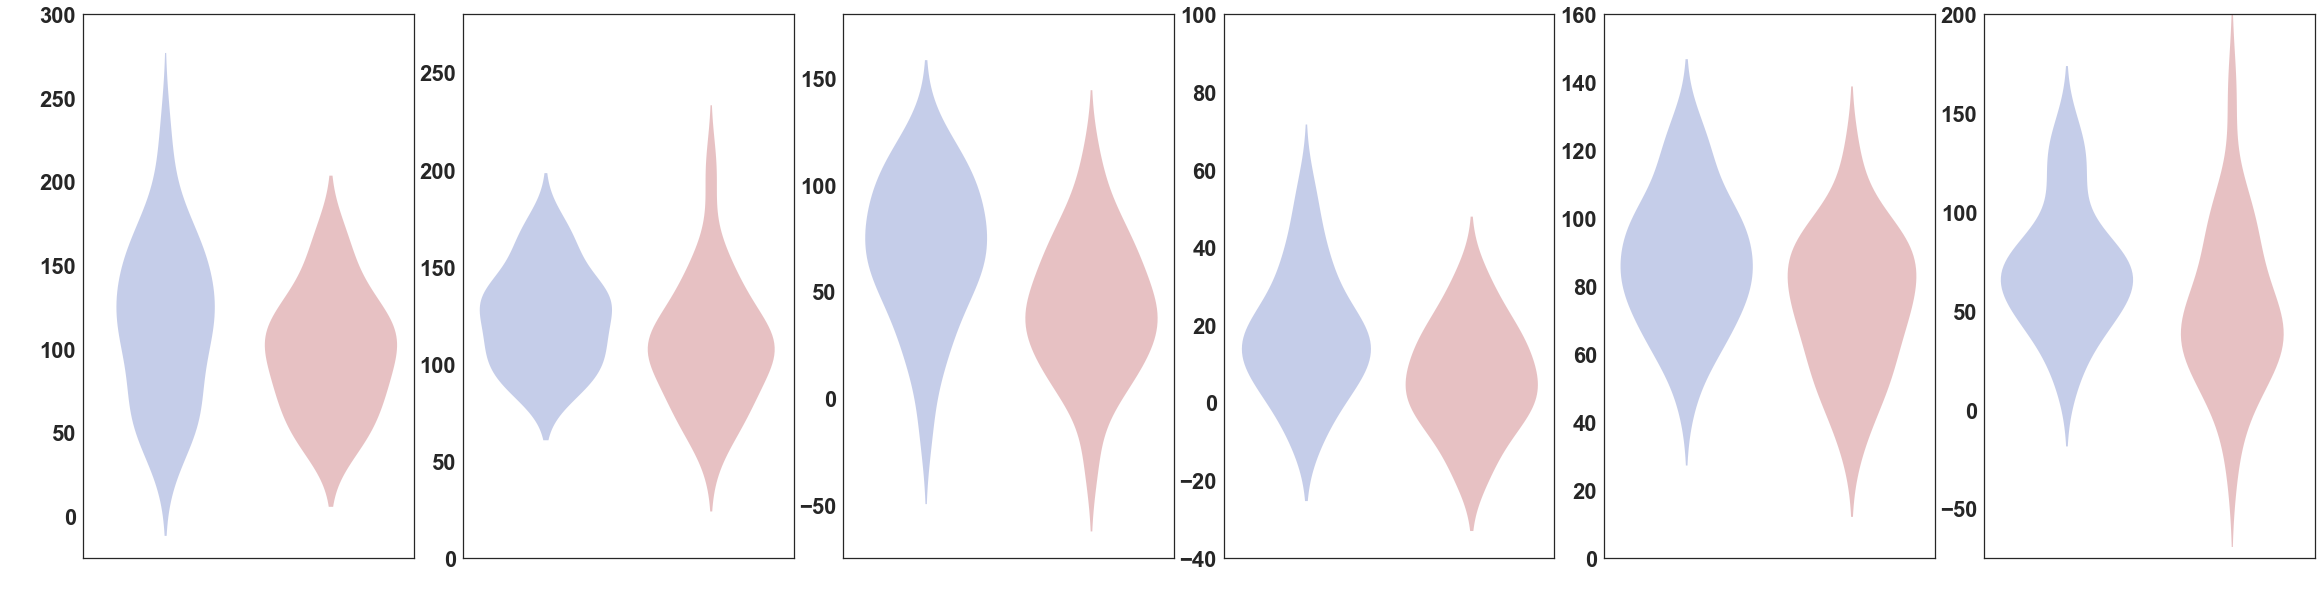

In [43]:
make_plot(measures,controls,patients, plt_type='violin2', save = 1,wspace=0.15, hspace=0.00001)

RN 0
SN 4
SN
STN 8
STN
Caud_Puta 12
Caud_Puta
Pall 16
Pall
DN 20
DN


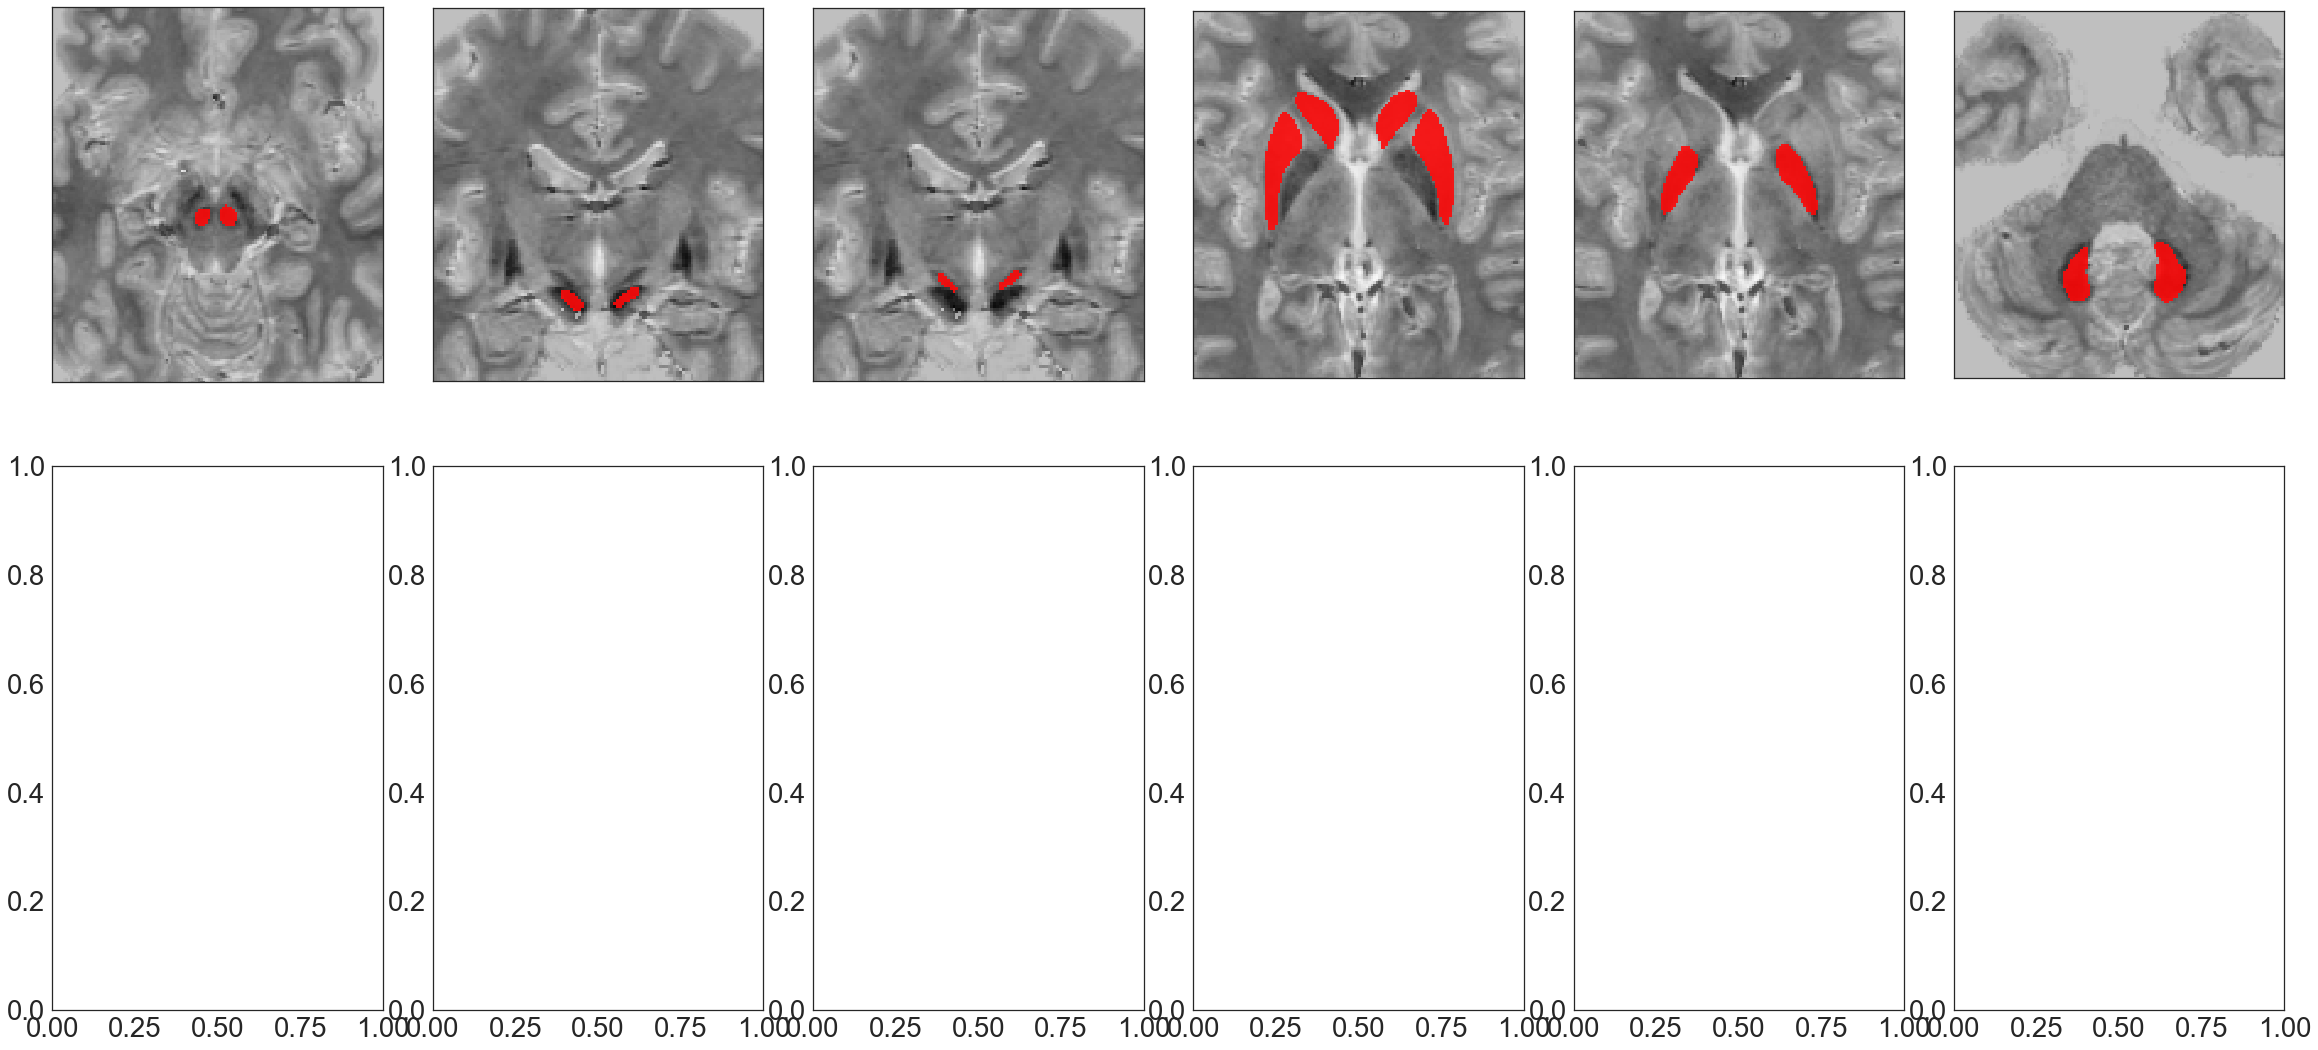

In [52]:
make_plot(measures,controls,patients, plt_type='img', save =1,wspace=0.15, hspace=0.00001)

In [32]:
def patch_violinplot():
    """Patch seaborn's violinplot in current axis to workaround matplotlib's bug ##5423."""
    from matplotlib.collections import PolyCollection
    ax = plt.gca()
    for art in ax.get_children():
        if isinstance(art, PolyCollection):
            art.set_edgecolor(None)

In [33]:
data = [controls['STN'], patients['STN']] 

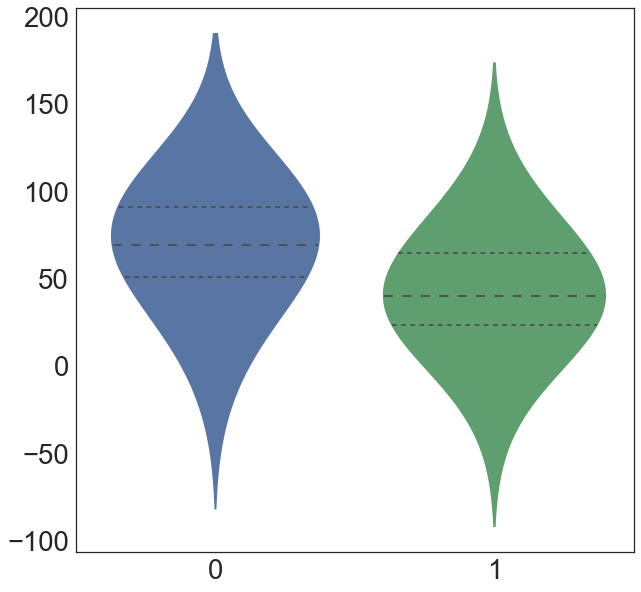

In [34]:
fig = plt.figure(figsize=(10,10))
x = sns.violinplot(data=data, inner= 'quart', bw=1)
patch_violinplot()



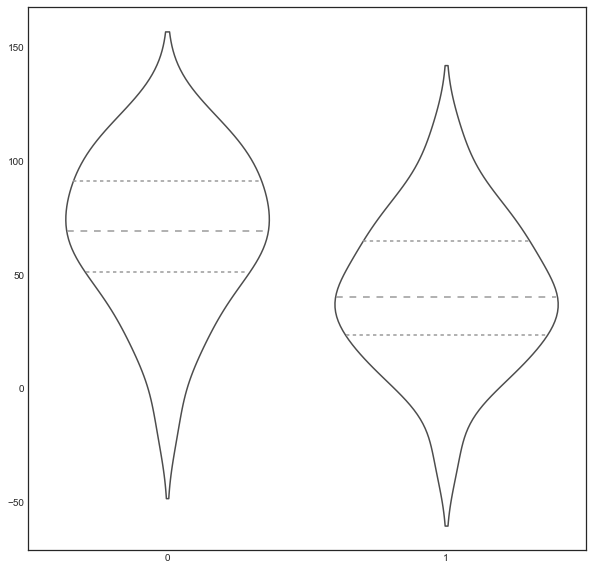

In [29]:
fig = plt.figure(figsize=(10,10))
x = sns.violinplot(data=data, inner= 'quart', bw=0.5,color="1")
patch_violinplot()